# Analysis and Prediction of subscriptions to a bank term deposit #

### From data cleaning to model development: How to deal with unbalanced data sets in machine learning using SMOTE technique ###

In [1]:
library(ggplot2)
library(readxl)
library(tidyverse)
library(caret)
library(corrplot)
library(pROC)
library(car)
library(stargazer)
library(GGally)
library(arsenal)
library(arm)
library(rpart)
library(randomForest)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


corrplot 0.92 loaded

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some



Pl

In [2]:
#open the data set and save it as "term"
term <- read_excel("/Users/jaimerd/Desktop/Term-deposit-subscription/term.xlsx")

## Data cleaning and feature engineering ## 

In [3]:
#convert categorical variables into factors
term <- term %>% mutate_if(is.character,as.factor)

#numeric variables
data_numeric <- term[sapply(term, is.numeric)]

Outliers in numeric variables

age > 100,n
<lgl>,<int>
FALSE,40967
TRUE,2


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  17.00   32.00   38.00   40.03   47.00   95.00       2 

campaign > 33,n
<lgl>,<int>
FALSE,40951
TRUE,18


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00    1.00    2.00    2.55    3.00   33.00      18 

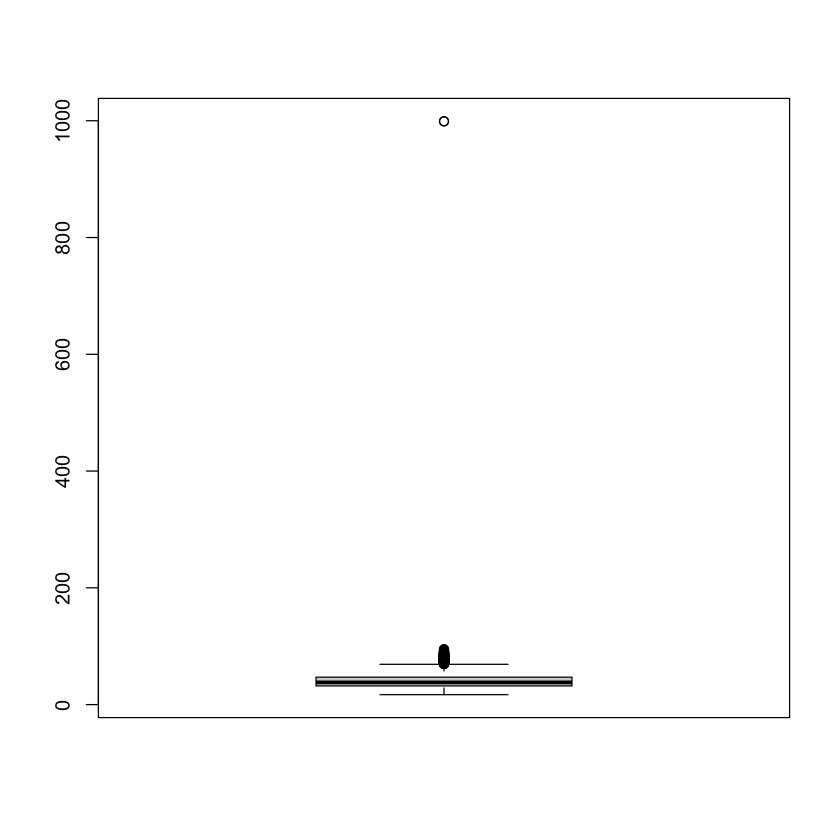

In [4]:
#age
boxplot(term$age)
term %>% count(age>100)
term$age[term$age >100] <- NA
summary(term$age)

#campaign () 
term %>% count(campaign>33)
term$campaign[term$campaign > 33] <- NA
summary(term$campaign)

#The same process was applied to all numerical variables, yet no outliers were detected among them.

Categorical variables

In [5]:
#month
levels(term$month)[levels(term$month) == "july"] <- "jul"

#day of the week
levels(term$day_of_week)[levels(term$day_of_week) == "tues"] <- "tue"


##missing values = converted them to the level with the highest frequency 
term$marital_status[is.na(term$marital_status)] <- 'married'

In [6]:
#omit missing values
term <- na.omit(term)


## Correlations and Descriptive Analysis ##

Statistic Summary by comparing all variables with the target variable (subscribed). The p-value for numerical variables was calculated using ANOVA, while for categorical variables, the chi-squared test (chisq.test) was employed.. Taking <0.01 as the reference value for statistical significance.

In [7]:
configuration <- tableby.control(
  test = T,
  total = FALSE,
  numeric.test = "anova", cat.test = "chisq",
  numeric.stats = c("meansd"),
  cat.stats = c("countpct"))

descriptive_stats <- tableby(subscribed ~ .,
                     data = term,
                     control = configuration)

summary(descriptive_stats, title = "Descriptive Statistic", text= TRUE)



Table: Descriptive Statistic

|                       |     no (N=36316)      |     yes (N=4633)      | p value|
|:----------------------|:---------------------:|:---------------------:|-------:|
|ID                     |                       |                       | < 0.001|
|-  Mean (SD)           | 19249.111 (11381.580) | 30197.602 (10708.436) |        |
|age                    |                       |                       | < 0.001|
|-  Mean (SD)           |    39.918 (9.906)     |    40.888 (13.792)    |        |
|occupation             |                       |                       | < 0.001|
|-  admin.              |     8987 (24.7%)      |     1351 (29.2%)      |        |
|-  blue-collar         |     8593 (23.7%)      |      638 (13.8%)      |        |
|-  entrepreneur        |      1331 (3.7%)      |      123 (2.7%)       |        |
|-  housemaid           |      954 (2.6%)       |      106 (2.3%)       |        |
|-  management          |      2585 (7.1%)      |      

Statistical significance is found in variables such as age, occupation, marital status, education level, and credit default. However, variables like 'housing_loan' and 'personal_loan' do not show statistical significance. This finding contradicts the assertions of Colaianni et al. (2016), who suggested that loan status is a major factor influencing subscription decisions. When analysing the occupations of the subscribers, a notable majority fall into the category of 'Admin', with 29.2% (Figure 1). Regarding the marital status, a significant portion of subscribers were married, accounting for 54.6% (Figure 2), which corroborates H2. Finally, the majority of subscribers, 90.5%, had no credit default history (Figure 4). The presence of a default often indicates financial instability or a history of poor credit management, which could reduce a person's willingness to commit money to a term deposit.

The analysis reveals that all variables pertaining to the last customer contact during the marketing campaign, as well as other variables, exhibit statistical significance. Focusing on the method of contact, the data indicates that most customers, 60.8% of non-subscribers and 83.1% of subscribers, were contacted via cellular (Figure 8). Additionally, a significant proportion of subscribers were successfully contacted in May (19.1%), August (14.0%), and July (14.0%) (Figure 6). The data also demonstrates that subscribers, on average, had fewer contacts (mean of 2.05) compared to non-subscribers (mean of 2.613) (Figure 7). Finally, by examining the results of the previous campaigns ("poutcome"), it is found that most of new subscribers (67.6%) in this campaign were customers who had not been contacted in previous campaigns.


All of the economic and social variables demonstrate statistical significance. It is observed that subscribers are more likely during periods of declining employment rates. Regarding the consumer price index (cons_price_idx), subscribers had an average index of 93.354, slightly lower than the average of 93.604 for non-subscribers. In terms of the consumer confidence index (cons_conf_idx), subscribers were exposed to a higher confidence index during the campaign, aligning with H3. Finally with respect to the 3-month Euribor rate (euribor_3m), subscribing customers had an average rate of 2.117, which is lower than the average rate of 3.804 for non-subscribers.

### Graphs ###

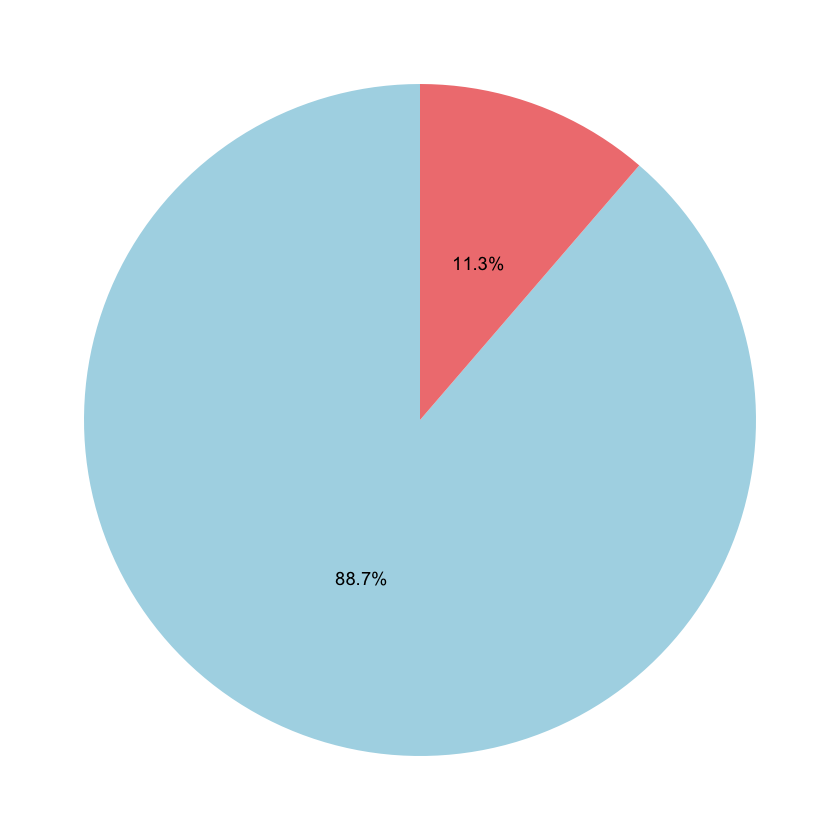

In [8]:
#graph comparing subscribed yes vs no 
#calculate the percentage of "yes" "no". 1. A table is created to see the frequency of "yes" and "no". 2. with prop table each value is divided by the sum of the total, so the percentage is calculated when the table is multiplied by 100. 3. the table is converted into a data frame 
per_subscribed <- data.frame(prop.table(table(term$subscribed)) * 100)
ggplot(per_subscribed, aes(x = "", y = Freq, fill = Var1)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
  theme_void() +
  scale_fill_manual(values = c("lightblue", "lightcoral")) +
  geom_text(aes(label = sprintf("%.1f%%", Freq)), position = position_stack(vjust = 0.5))+
  theme(legend.position = "none")

Some demographic and time variables

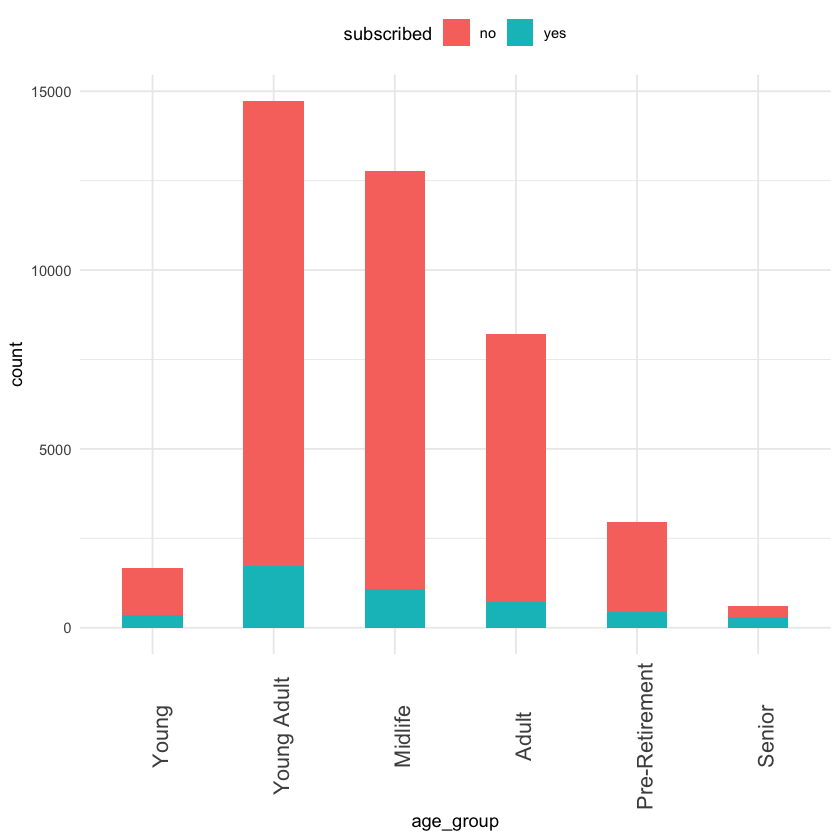

In [9]:
#Categorize ages into groups and create a bar plot of subscriptions by age group
term$age_group <- cut(term$age, breaks = c(0, 25, 35, 45, 55, 65, Inf), labels = c("Young", "Young Adult", "Midlife", "Adult", "Pre-Retirement", "Senior"))
ggplot(term, aes(x=age_group, fill = subscribed)) +
  geom_bar(position= "stack", width = 0.5) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, size=13))+
  theme(legend.position = "top")

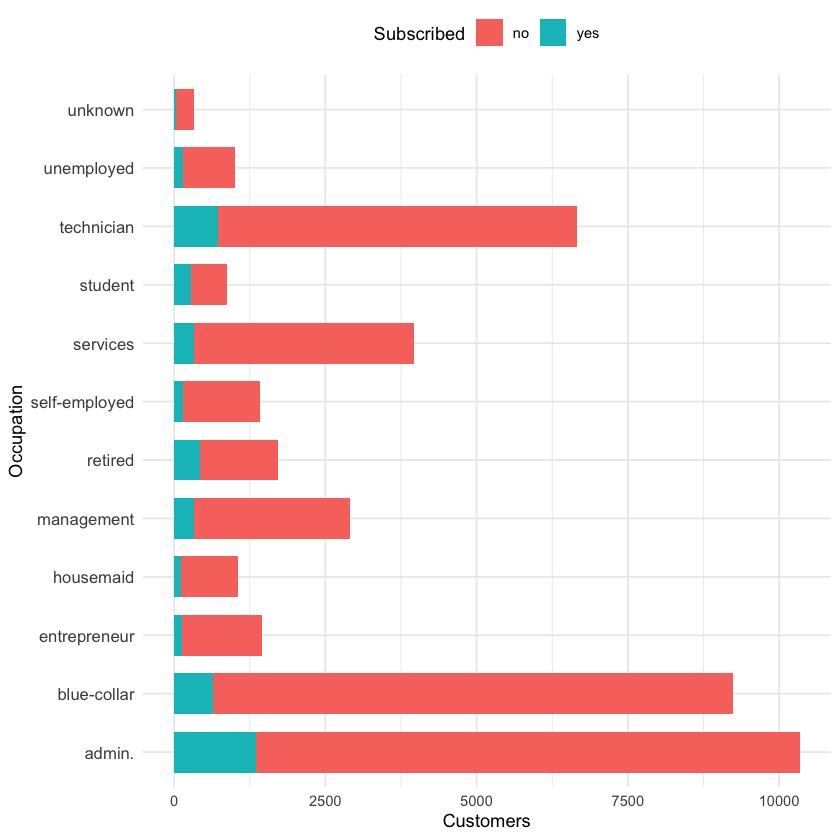

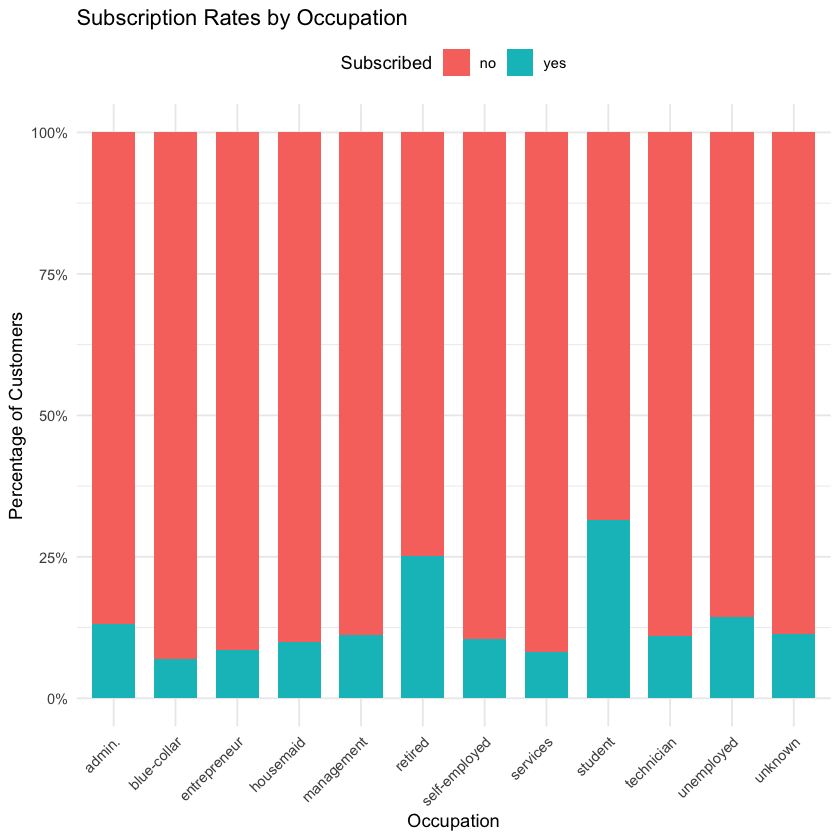

In [10]:
#bar plot showing the occupation 
ggplot(term, aes(x = occupation, fill = subscribed)) +
  geom_bar(position = "stack", width = 0.7) +
  labs(
       x = "Occupation",
       y = "Customers",
       fill = "Subscribed") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10),legend.position = "top") +
  coord_flip()

  #Subscription Rates by occupation
ggplot(term, aes(x = occupation, fill = subscribed)) +
  geom_bar(position = "fill", width = 0.7) +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    x = "Occupation",
    y = "Percentage of Customers",
    fill = "Subscribed",
    title = "Subscription Rates by Occupation"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "top")

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


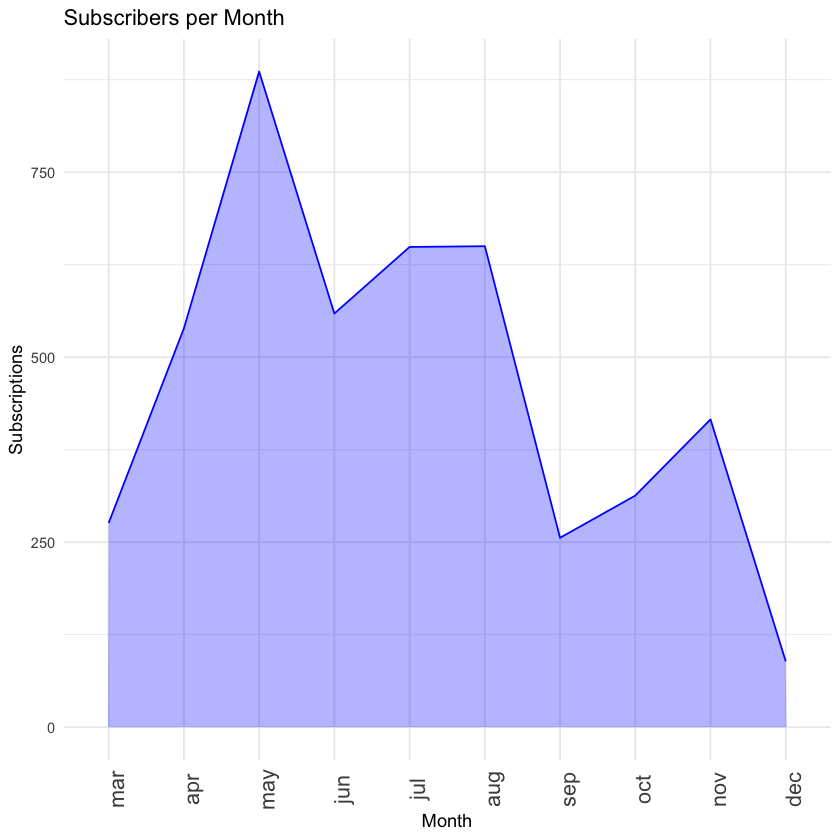

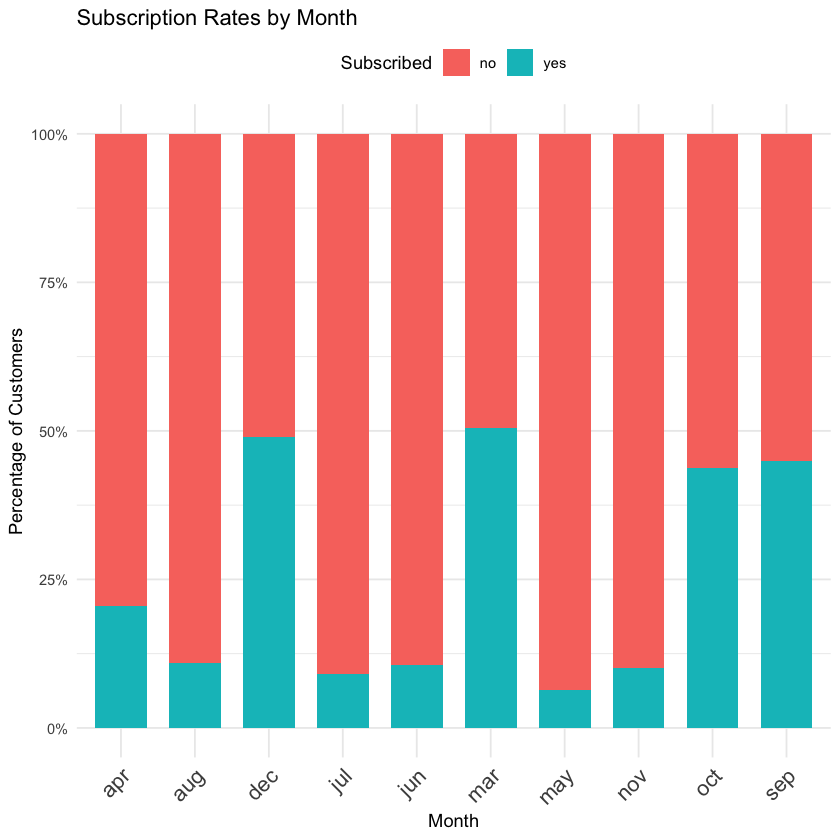

In [11]:
#subscriptions per month
#Create a data frame with the number of subscribers and group them by month in order.
month_subs <- term %>% 
  filter(subscribed == "yes") %>%
  mutate(month = factor(month, levels = c("mar", "apr", "may", "jun", "jul", "aug", "sep", "oct","nov", "dec"))) %>%
  group_by(month) %>%
  summarise(subscriptions = n())

#line graph with subscribers per month
ggplot(month_subs, aes(x = month, y = subscriptions, group=1)) +
  geom_area(fill = "blue", alpha = 0.3) +
  geom_line(color = "blue", size =0.5) + 
  labs(title = "Subscribers per Month",
       x = "Month",
       y = "Subscriptions") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90 ,size = 13))

#bar graph with the subscription rates by month
ggplot(term, aes(x = month, fill = subscribed)) +
  geom_bar(position = "fill", width = 0.7) +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    x = "Month",
    y = "Percentage of Customers",
    fill = "Subscribed",
    title = "Subscription Rates by Month"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 13),legend.position = "top")

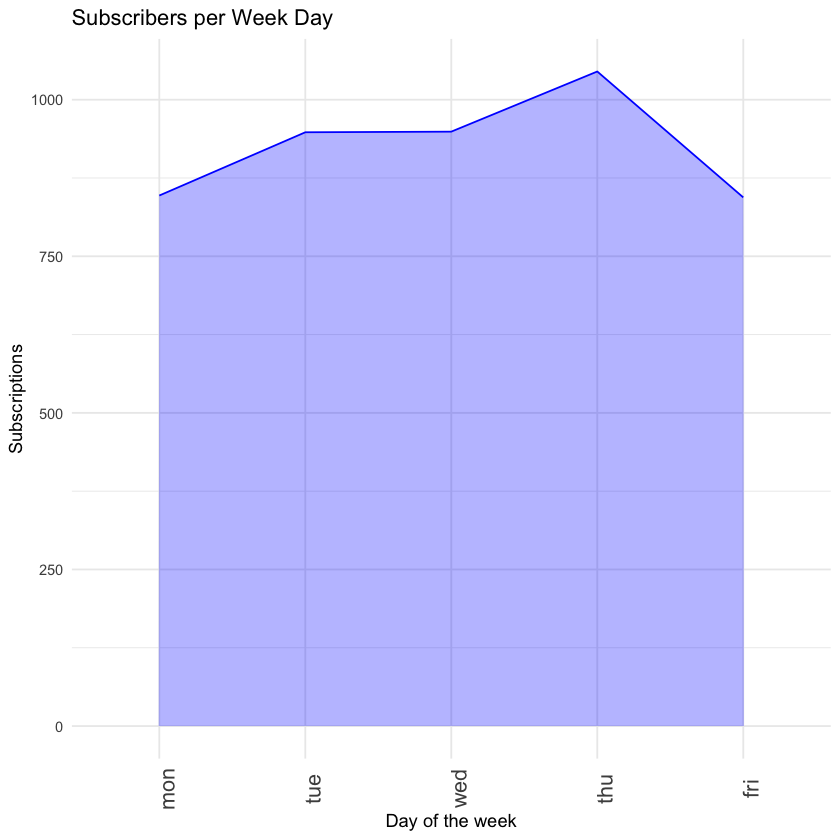

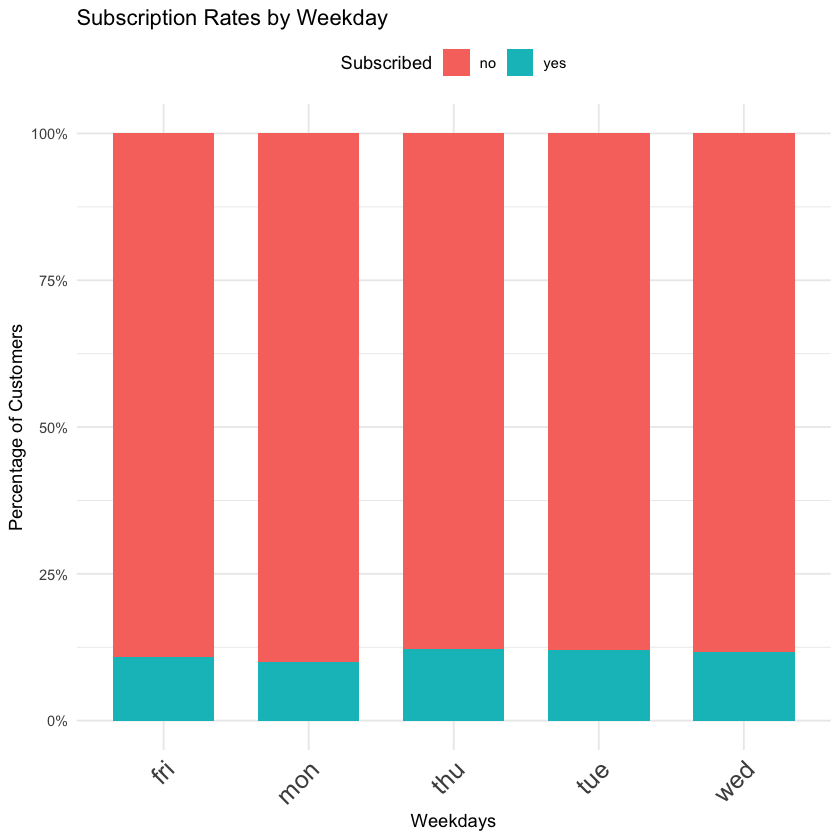

In [12]:
#subscriptions per weekday
#Create a data frame with the number of subscribers and group them by weekday in order.
week_subs <- term %>% 
  filter(subscribed == "yes") %>%
  mutate(day_of_week = factor(day_of_week, levels = c("mon", "tue", "wed", "thu", "fri"))) %>%
  group_by(day_of_week) %>%
  summarise(subscriptions = n())

#line graph with subscribers per weekday
ggplot(week_subs, aes(x = day_of_week, y = subscriptions, group=1)) +
  geom_area(fill = "blue", alpha = 0.3) +
  geom_line(color = "blue", size =0.5) +
  labs(title = "Subscribers per Week Day",
       x = "Day of the week",
       y = "Subscriptions") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, size = 13))

#Subscription Rates by Weekday
ggplot(term, aes(x = day_of_week, fill = subscribed)) +
  geom_bar(position = "fill", width = 0.7) +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    x = "Weekdays",
    y = "Percentage of Customers",
    fill = "Subscribed",
    title = "Subscription Rates by Weekday"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1,size = 15),legend.position = "top")

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
i Please use tidy evaluation idioms with `aes()`.
i See also `vignette("ggplot2-in-packages")` for more information."


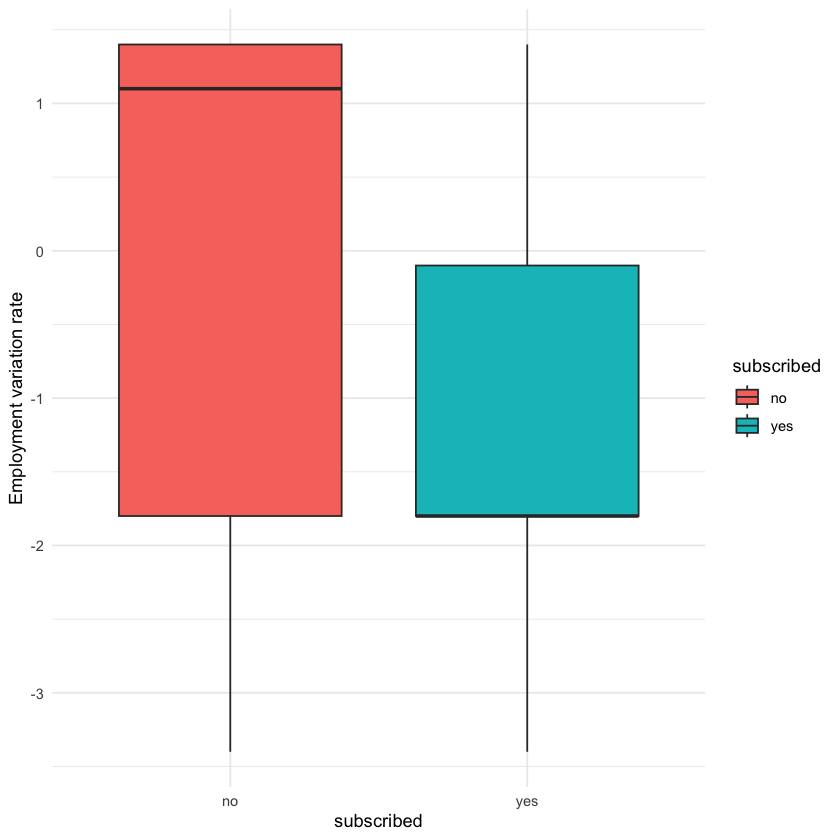

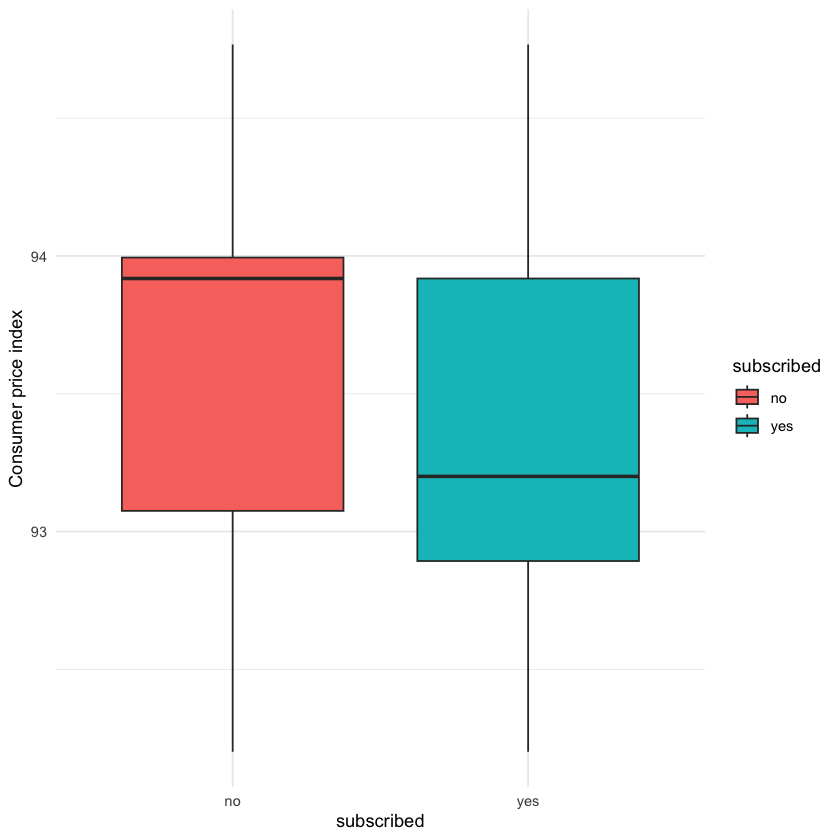

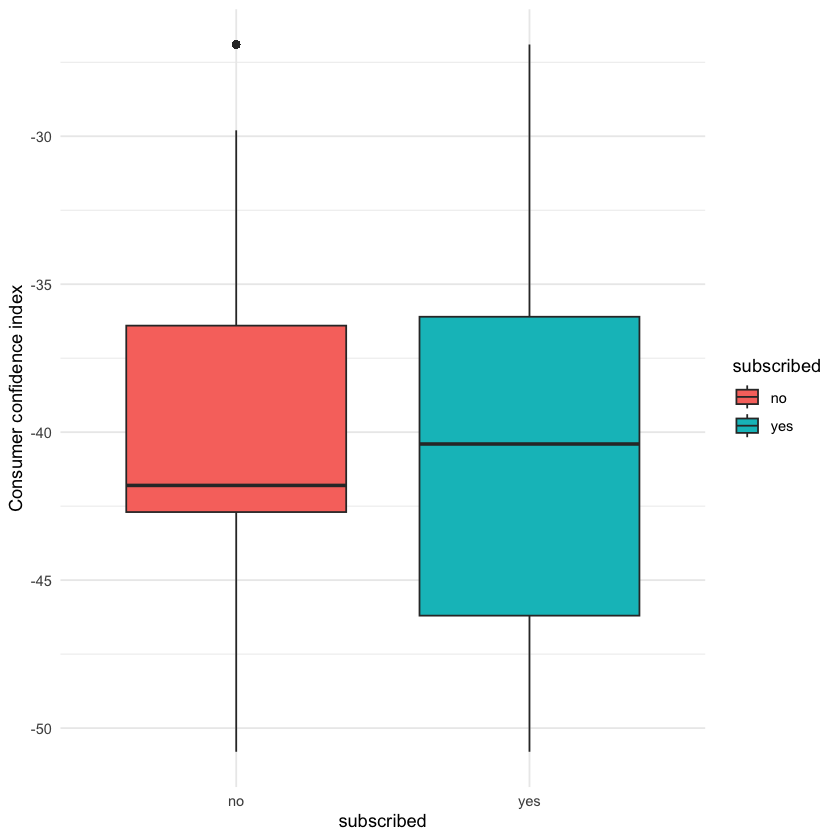

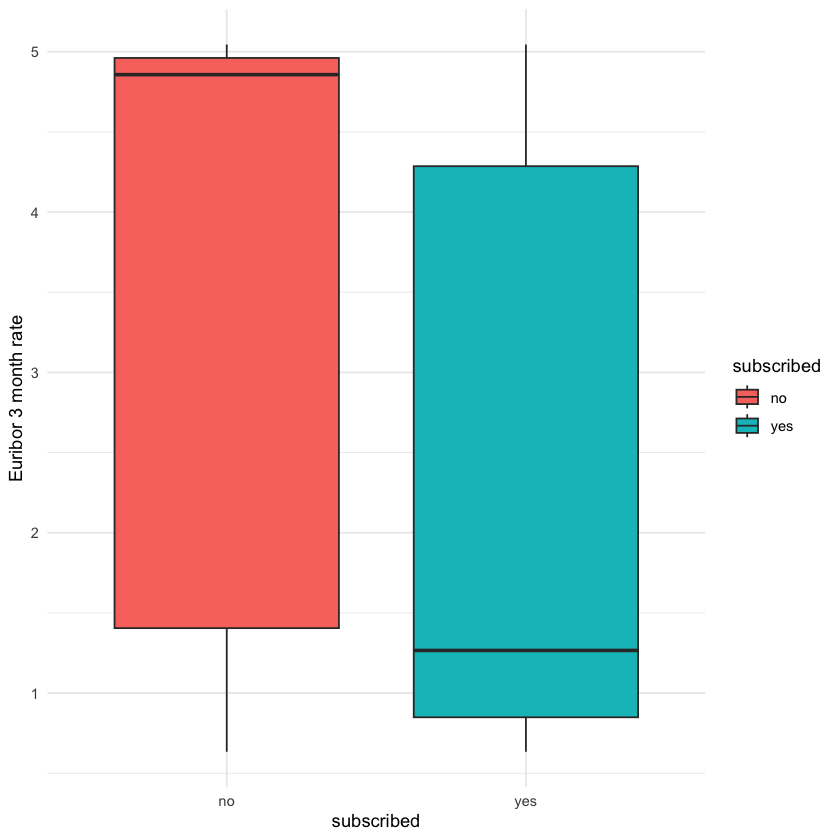

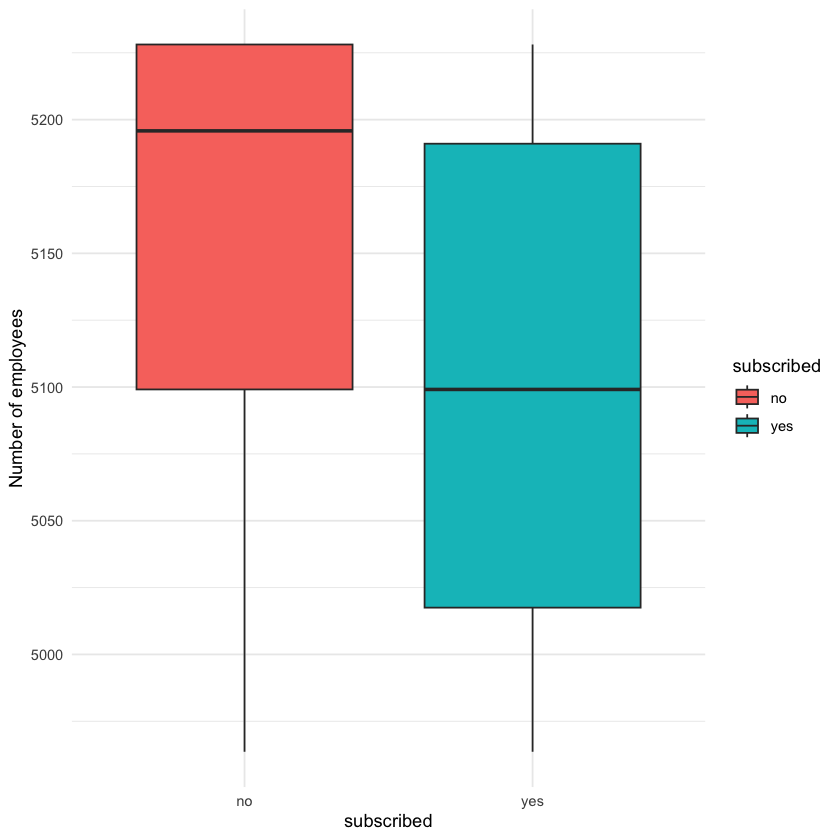

In [13]:
# Function to create box plot
crear_box_plot <- function(data, variable, label_y) {
  ggplot(data, aes_string(y = variable, x = "subscribed", fill = "subscribed")) +
    geom_boxplot() +
    labs(y = label_y) +
    theme_minimal()
}

# Economic variables
crear_box_plot(term, "emp_var_rate", "Employment variation rate")
crear_box_plot(term, "cons_price_idx", "Consumer price index")
crear_box_plot(term, "cons_conf_idx", "Consumer confidence index")
crear_box_plot(term, "euribor_3m", "Euribor 3 month rate")
crear_box_plot(term, "n_employed", "Number of employees")


## Models Development using the Unbalanced Dataset

### Logistic Regression, Decision Tree and Random Forest ###

In [14]:
levels(term$subscribed)

#omit missing values
term <- na.omit(term)

#split the data into train (80%) and test (20%) data set. 
set.seed(40425150)
index <- createDataPartition(term$subscribed, p=0.8, list=FALSE)
train <- term[index,]
test <- term[-index,]

[1] "no"  "yes"

### Logistic Regression 

Build Logistic Regression models and select the most accurate

In [15]:
#1 model
formula1 = subscribed  ~ age + occupation + marital_status + euribor_3m + cons_conf_idx
model1 <- glm(formula = formula1 , data = train, family= "binomial")

#2 model
formula2 = subscribed  ~ age + occupation + marital_status + education_level + euribor_3m + cons_conf_idx
model2 <- glm( formula = formula2, data = train, family= "binomial" )

#3 model
formula3 = subscribed  ~ age + marital_status + credit_default + month + campaign + poutcome + emp_var_rate 
model3 <- glm(formula = formula3, data = train, family= "binomial")

#4 model
formula4 = subscribed ~ day_of_week + occupation + contact_method + campaign + month + euribor_3m + cons_price_idx + pdays
model4 <- glm(formula = formula4 , data = train, family = "binomial")


**Comparison of the models**

In [16]:
logisticPseudoR2s <- function(LogModel) {
  dev <- LogModel$deviance
  nullDev <- LogModel$null.deviance
  modelN <- length(LogModel$fitted.values)
  R.l <- 1 - dev / nullDev
  R.cs <- 1- exp ( -(nullDev - dev) / modelN)
  R.n <- R.cs / ( 1 - ( exp (-(nullDev / modelN))))
  cat("Pseudo R^2 for logistic regression\n")
  cat("Hosmer and Lemeshow R^2 ", round(R.l, 3), "\n")
  cat("Cox and Snell R^2 ", round(R.cs, 3), "\n")
  cat("Nagelkerke R^2 ", round(R.n, 3), "\n")
}

logisticPseudoR2s(model1)
logisticPseudoR2s(model2)
logisticPseudoR2s(model3)
logisticPseudoR2s(model4)


Pseudo R^2 for logistic regression
Hosmer and Lemeshow R^2  0.148 
Cox and Snell R^2  0.099 
Nagelkerke R^2  0.196 
Pseudo R^2 for logistic regression
Hosmer and Lemeshow R^2  0.149 
Cox and Snell R^2  0.1 
Nagelkerke R^2  0.197 
Pseudo R^2 for logistic regression
Hosmer and Lemeshow R^2  0.191 
Cox and Snell R^2  0.126 
Nagelkerke R^2  0.249 
Pseudo R^2 for logistic regression
Hosmer and Lemeshow R^2  0.201 
Cox and Snell R^2  0.133 
Nagelkerke R^2  0.262 


Model 4 is the best performing model among all those constructed. This model holds the lowest AIC and the highest p-pseudo R^2.

In [17]:
summary(model4)


Call:
glm(formula = formula4, family = "binomial", data = train)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.774e+01  4.042e+00  -6.864 6.69e-12 ***
day_of_weekmon          -1.797e-01  6.362e-02  -2.824 0.004740 ** 
day_of_weekthu           8.393e-02  6.129e-02   1.369 0.170855    
day_of_weektue           8.098e-02  6.346e-02   1.276 0.201947    
day_of_weekwed           1.557e-01  6.272e-02   2.482 0.013059 *  
occupationblue-collar   -3.100e-01  6.180e-02  -5.015 5.30e-07 ***
occupationentrepreneur  -2.449e-01  1.208e-01  -2.027 0.042641 *  
occupationhousemaid     -1.837e-01  1.357e-01  -1.354 0.175868    
occupationmanagement    -9.733e-02  8.132e-02  -1.197 0.231361    
occupationretired        2.426e-01  8.162e-02   2.972 0.002956 ** 
occupationself-employed -1.139e-01  1.130e-01  -1.008 0.313439    
occupationservices      -2.265e-01  7.847e-02  -2.886 0.003901 ** 
occupationstudent        2.376e-01  1.023e-01   

Customers contacted on a Wednesday (OR=1.16) are more likely to subscribe than those contacted on a Friday. However, compared to Friday, those who were contacted on a Monday (OR=0.83) are less likely to subscribe. The odds ratio (OR) quantifies the probability of an outcome occurring in relation to a specific exposure and it is commonly used in logistic regression (Szumilas, 2010). For instance, in this context, customers contacted on Wednesday have 1.16 times higher odds of subscribing compared to those contacted on Friday.

Compared to customers working as administrators, those employed in blue-collar roles (OR=0.74), services (OR=0.78), as entrepreneurs (OR=0.81), or as technicians (OR=0.90) are less likely to subscribe. In contract, customers who are retired (OR=1.32) or student (OR=1.33) show a significantly higher likelihood of subscribing compared to administrators.

Customers contacted by telephone (OR=0.78) are less likely to subscribe compared to those contacted by cellular. The fewer contacts made during the campaign (OR=0.95), the more likely a customer is to subscribe to the term deposit. Similarity, the fewer days that have passed since the customer was last contacted (OR=0.99), the higher the likelihood of subscription. These findings corroborate the results of Choi and Choi (2022), who observed similar relationships using a random forest algorithm.

Compared to customers who were contacted in April, those contacted in May (OR=0.55) are less likely to subscribed. In contrast, customers contacted in August (OR=1.5), December (OR=2.52), July (OR=1.59), June (1.40), March (OR=3.35), November (OR=1.16), September (OR=1.48), and October (OR=1.98) are significantly more likely to subscribe than those contacted in February. While this finding contradicts the observations made by Choi and Choi (2022), it is supported by Xie et. al. (2023), who identified the month of contact, day of the week, and occupation as the three most influential variables in determining the likelihood of subscription.

The consumer price index (OR=1.36) is positively correlated with subscription likelihood, indicating that as the index rises, the likelihood of subscribe rises. However, the Euribor 3-month rate (OR=0.59) has a negative relationship with subscription likelihood, meaning that a higher Euribor 3-month rate reduces the probability of a customer subscribing to the term deposit. Similarly, Moro et al. (2014), utilizing a neural network (NN) approach, also found a negative correlation between the Euribor rate and the likelihood of subscription.

**Assumptions checking**

[1] 1453

[1] 209

[1] 2

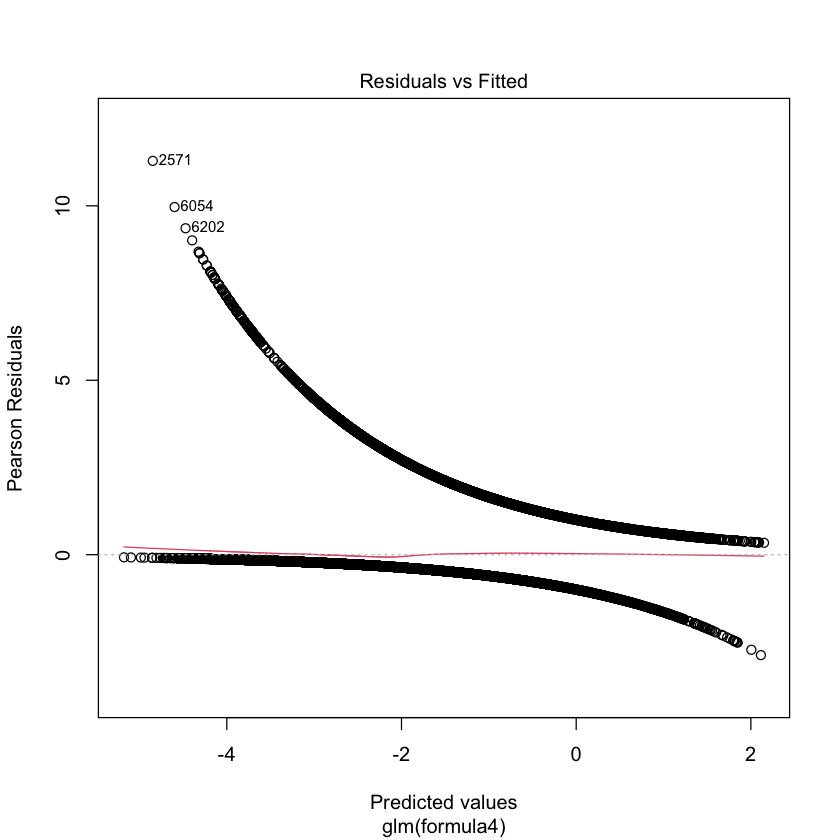

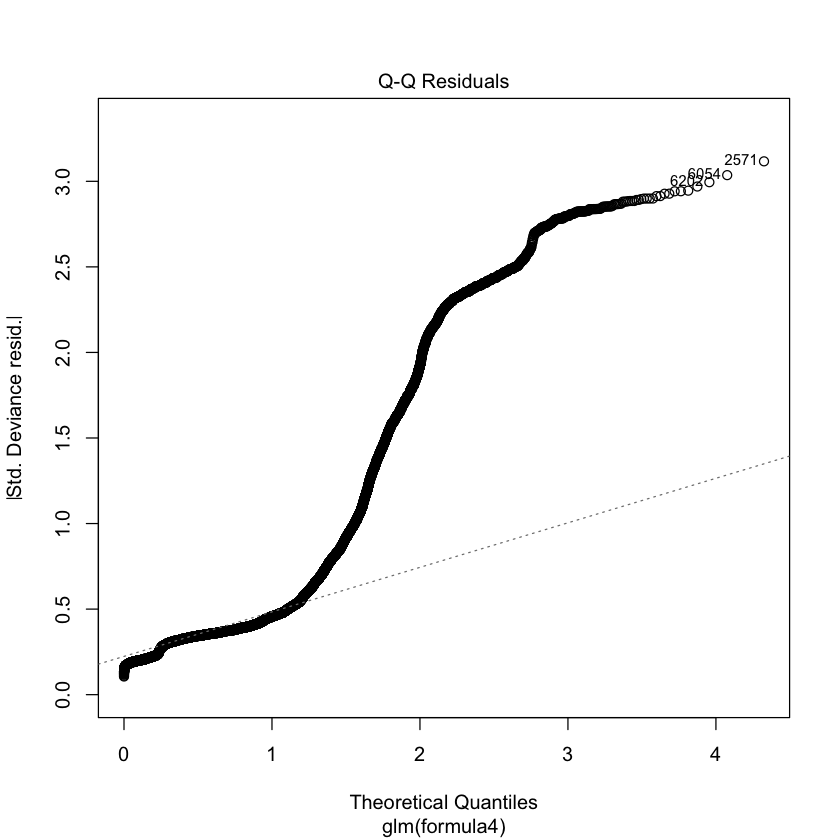

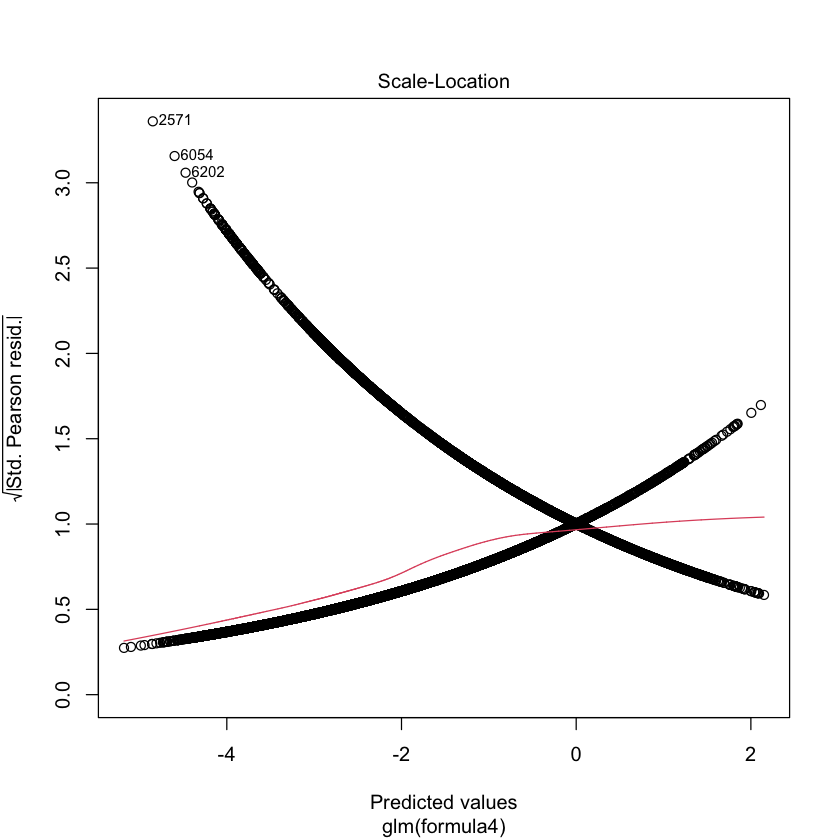

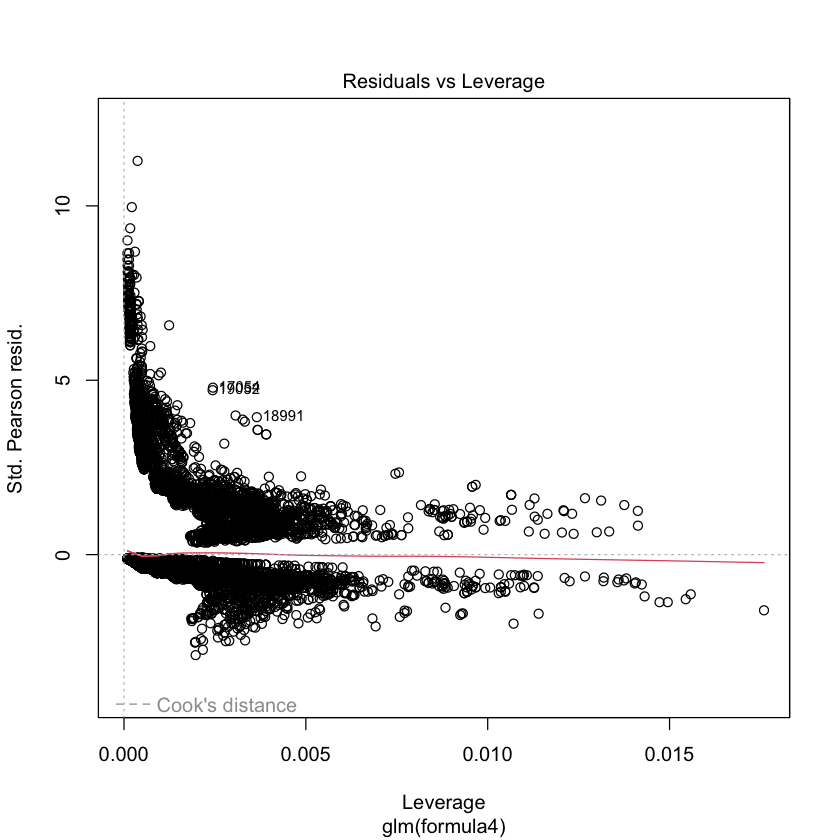

[1] 0

[1] 8535

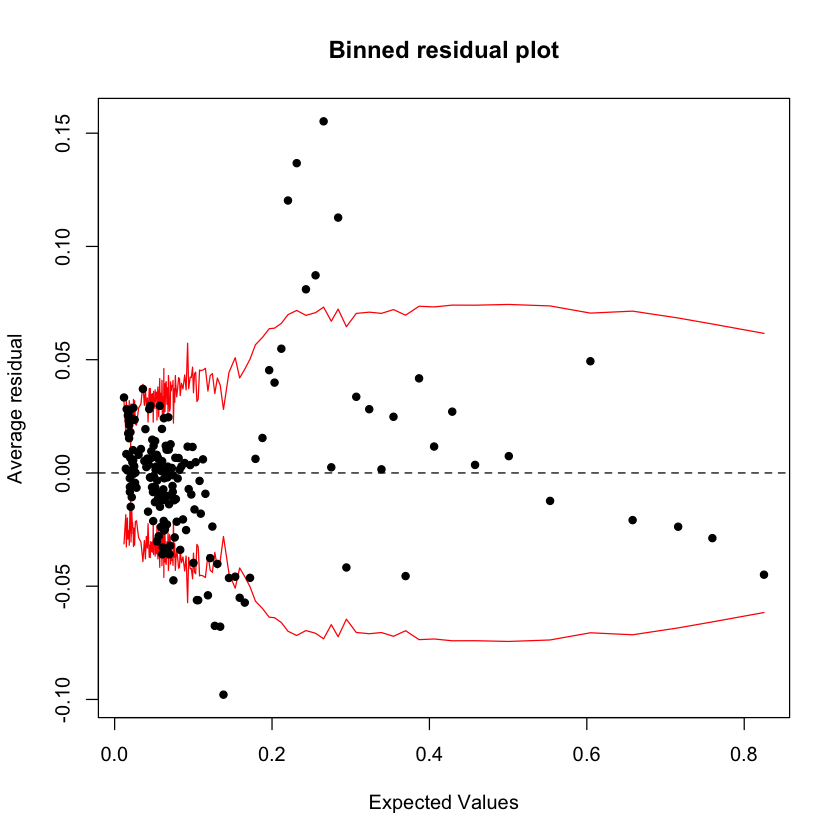

,GVIF,Df,GVIF^(1/(2*Df))
day_of_week,1.039494,4,1.004853
occupation,1.181566,11,1.007612
contact_method,1.527067,1,1.235745
campaign,1.041143,1,1.020364
month,2.804263,9,1.058958
euribor_3m,2.480884,1,1.575082
cons_price_idx,2.056299,1,1.433980
pdays,1.155520,1,1.074951


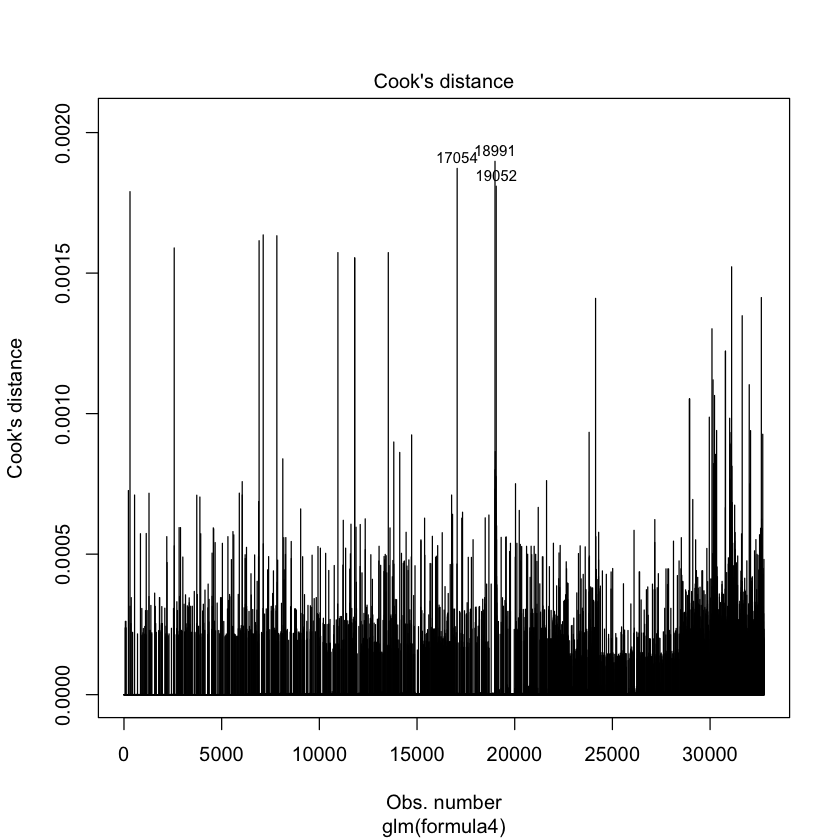

In [18]:
#residuals
train$standarisedResiduals <- rstandard(model4)
train$studentdResiduals <- rstudent(model4)
sum(train$standarisedResiduals > 1.96)
sum(train$standarisedResiduals > 2.58)
sum(train$standarisedResiduals > 3)
plot(model4)


#binned residual plot
binnedplot(fitted(model4), 
           residuals(model4, type = "response"), 
           col.pts = 1, 
           col.int = "red")



#influential cases
train$cook <- cooks.distance(model4)
sum(train$cook > 1)

train$leverage <- hatvalues(model4)
sum(train$leverage > 0.0009)



plot(model4,which=4)

#multicollinearity
vif(model4)

#linearity of the logit (log of numerical variables)
train$log_camp <- log(train$campaign)*train$campaign
train$log_pdays <- log(train$pdays)*train$pdays
train$log_euribor <- log(train$euribor_3m)*train$euribor_3m
train$log_cons <- log(train$cons_price_idx)*train$cons_price_idx



formula_linea = subscribed ~ day_of_week + occupation + contact_method + campaign + month + pdays + euribor_3m + cons_price_idx + log_camp + log_pdays +log_euribor +log_cons
model_check <- glm(formula = formula_linea , data = train, family = "binomial")



The shaded red areas represent the range where approximately 95% of the observations are expected to be found. While not all values fall within this red area, less than 5% of the observations lie outside these boundaries.

There are no variables in the dataset with Generalized Variance Inflation Factor (GVIF) values exceeding the threshold of 10. This threshold is commonly used as a benchmark to evaluate the presence of multicollinearity.

When examining the influential cases within the model, no value has a Cook's Distance greater than 1. However, there are 8535 instances with a leverage higher than 0.0009.


Lastly, it appears that the linearity of the logit assumption is violated, as the log of numerical variables are statistically significant for the model. This violation leads to reduced confidence in the model's generalizability to the population from which the sample was drawn.

**Model Performance with test data set**

In [19]:
#Predictions with test data

predictions <- predict(model4,test, type = "response")
class_pred <- as.factor(ifelse(predictions > 0.5, "yes", "no"))
postResample(class_pred, test$subscribed)
conf_matrix <- confusionMatrix(class_pred, test$subscribed, positive = "yes")
conf_matrix

Accuracy     Kappa 
0.9005984 0.3036704

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  7162  713
       yes  101  213
                                         
               Accuracy : 0.9006         
                 95% CI : (0.8939, 0.907)
    No Information Rate : 0.8869         
    P-Value [Acc > NIR] : 3.779e-05      
                                         
                  Kappa : 0.3037         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.23002        
            Specificity : 0.98609        
         Pos Pred Value : 0.67834        
         Neg Pred Value : 0.90946        
             Prevalence : 0.11308        
         Detection Rate : 0.02601        
   Detection Prevalence : 0.03834        
      Balanced Accuracy : 0.60806        
                                         
       'Positive' Class : yes            
                                         

Setting direction: controls < cases



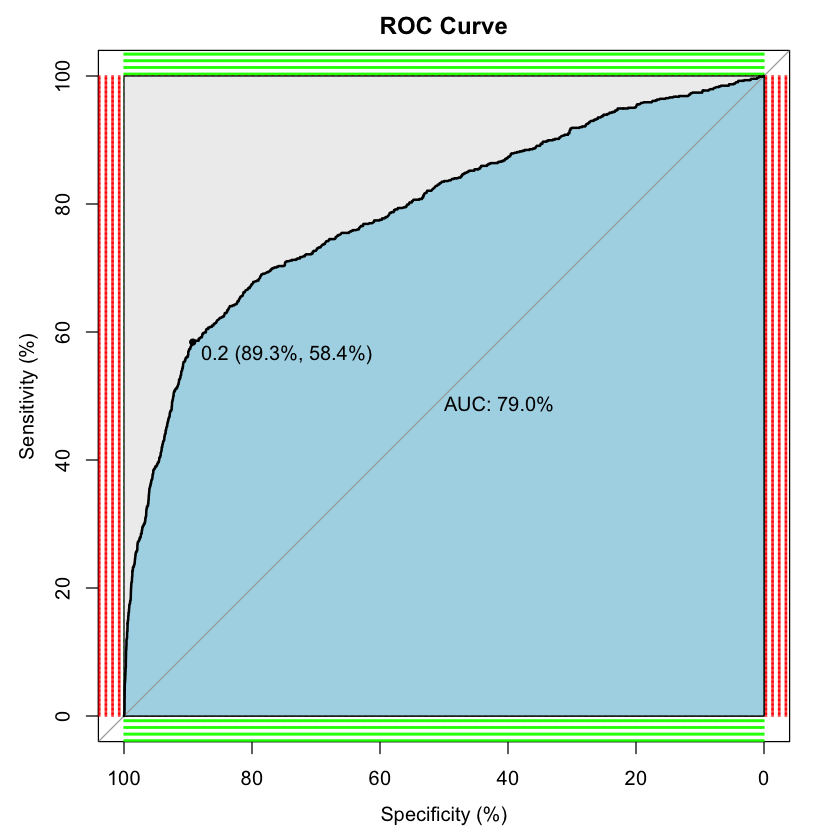

In [20]:
#ROC Curve
r <- multiclass.roc(test$subscribed, predictions, percent = TRUE)
roc <- r[['rocs']]
r1 <- roc[[1]]
plot.roc(r1,
         print.auc=TRUE,
         auc.polygon=TRUE,
         grid=c(0.1, 0.2),
         grid.col=c("green", "red"),
         max.auc.polygon=TRUE,
         auc.polygon.col="lightblue",
         print.thres=TRUE,
         main= 'ROC Curve')

### Decision Tree Classifier ###

In [21]:
#build decision tree with all variables except ID and contact duration
tree <- rpart(subscribed ~ age + occupation + marital_status + education_level + credit_default + housing_loan + personal_loan + contact_method + month + day_of_week + campaign + pdays + previous_contacts + poutcome + emp_var_rate + cons_price_idx +cons_conf_idx + euribor_3m + n_employed, data = train, method = "class")

**Model Performace with test dataset**

In [22]:
#Predictions with test data
predictions_tree <- predict(tree, test, type = "class")
postResample(predictions_tree, test$subscribed)
cm_tree <- confusionMatrix(predictions_tree, test$subscribed)
cm_tree

Accuracy     Kappa 
0.9004762 0.2754768

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  7190  742
       yes   73  184
                                          
               Accuracy : 0.9005          
                 95% CI : (0.8938, 0.9069)
    No Information Rate : 0.8869          
    P-Value [Acc > NIR] : 4.394e-05       
                                          
                  Kappa : 0.2755          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9899          
            Specificity : 0.1987          
         Pos Pred Value : 0.9065          
         Neg Pred Value : 0.7160          
             Prevalence : 0.8869          
         Detection Rate : 0.8780          
   Detection Prevalence : 0.9686          
      Balanced Accuracy : 0.5943          
                                          
       'Positive' Class : no              
                        

Setting direction: controls < cases



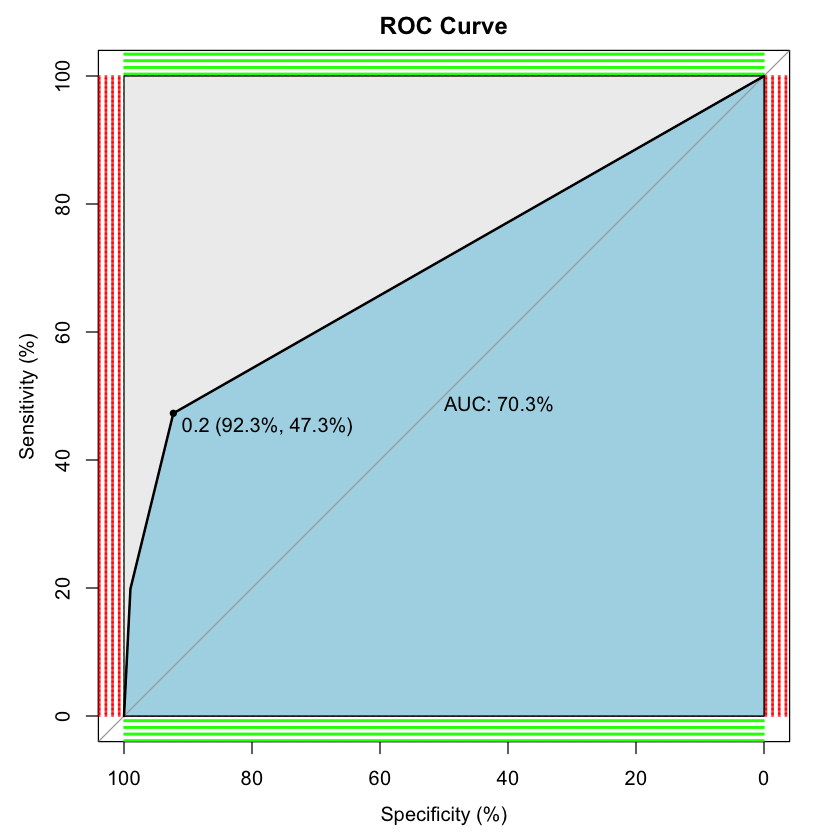

In [23]:
#ROC Curve
predictions_tree_1 <- predict(tree, test, type = "prob")
probabilities_tree <- predictions_tree_1[, "yes"]

r1 <- multiclass.roc(test$subscribed, probabilities_tree, percent = TRUE)
roc1 <- r1[['rocs']]
r2 <- roc1[[1]]
plot.roc(r2,
         print.auc=TRUE,
         auc.polygon=TRUE,
         grid=c(0.1, 0.2),
         grid.col=c("green", "red"),
         max.auc.polygon=TRUE,
         auc.polygon.col="lightblue",
         print.thres=TRUE,
         main= 'ROC Curve')

### Random Forest ###

In [24]:
rf <- randomForest(subscribed ~ age + occupation + marital_status + education_level + credit_default + housing_loan + personal_loan + contact_method + month + day_of_week + campaign + pdays + previous_contacts + poutcome + emp_var_rate + cons_price_idx +cons_conf_idx + euribor_3m + n_employed, data = train)


**Model Performance with test data**

In [25]:
#Confusion Matrix
pred_rf <- predict(rf,test)
cm_rf <- confusionMatrix(pred_rf,test$subscribed,positive = "yes")
cm_rf


Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  7066  652
       yes  197  274
                                          
               Accuracy : 0.8963          
                 95% CI : (0.8895, 0.9028)
    No Information Rate : 0.8869          
    P-Value [Acc > NIR] : 0.003487        
                                          
                  Kappa : 0.3421          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.29590         
            Specificity : 0.97288         
         Pos Pred Value : 0.58174         
         Neg Pred Value : 0.91552         
             Prevalence : 0.11308         
         Detection Rate : 0.03346         
   Detection Prevalence : 0.05752         
      Balanced Accuracy : 0.63439         
                                          
       'Positive' Class : yes             
                        

Setting direction: controls < cases



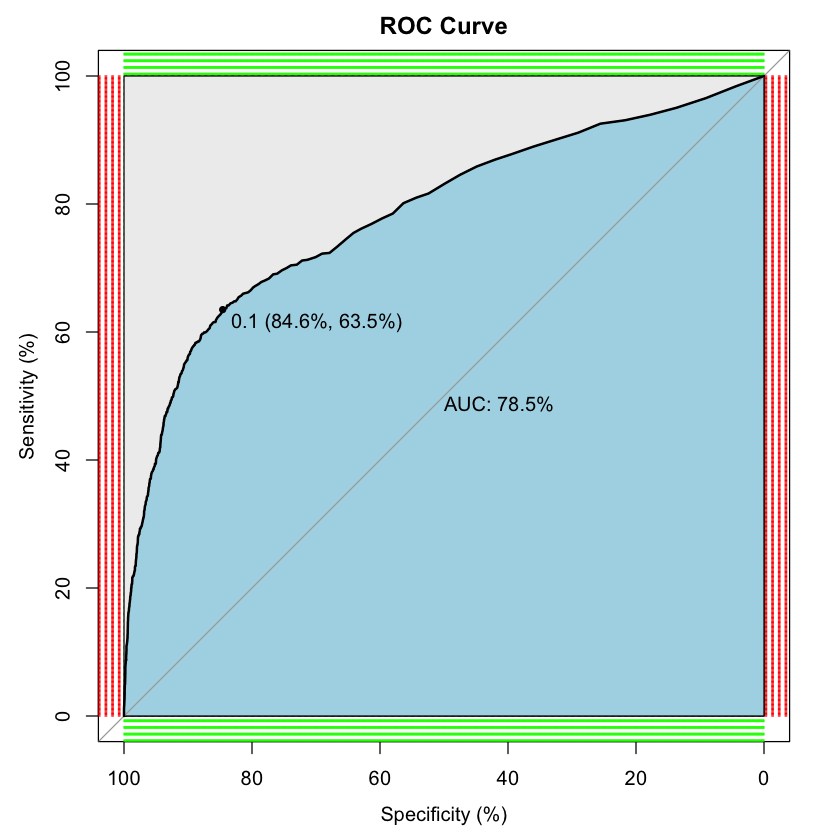

In [26]:
#ROC Curve
predictions_rf_1 <- predict(rf, test, type = "prob")
probabilities_rf <- predictions_rf_1[, "yes"]

r2 <- multiclass.roc(test$subscribed, probabilities_rf, percent = TRUE)
roc2 <- r2[['rocs']]
r3 <- roc2[[1]]
plot.roc(r3,
         print.auc=TRUE,
         auc.polygon=TRUE,
         grid=c(0.1, 0.2),
         grid.col=c("green", "red"),
         max.auc.polygon=TRUE,
         auc.polygon.col="lightblue",
         print.thres=TRUE,
         main= 'ROC Curve')

### Comparative of Models Performance ###

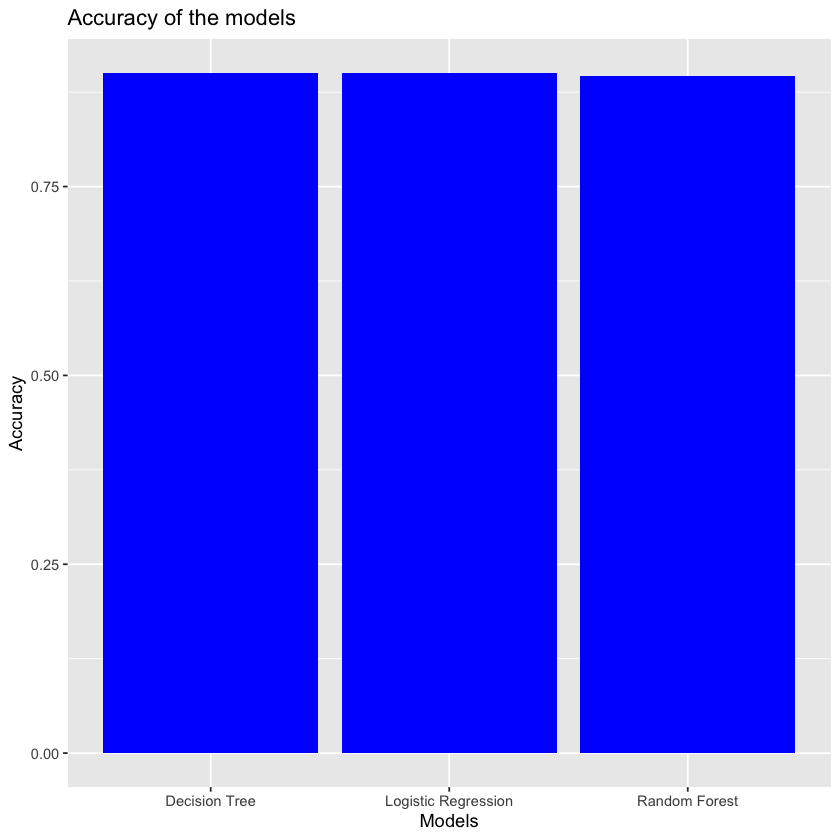

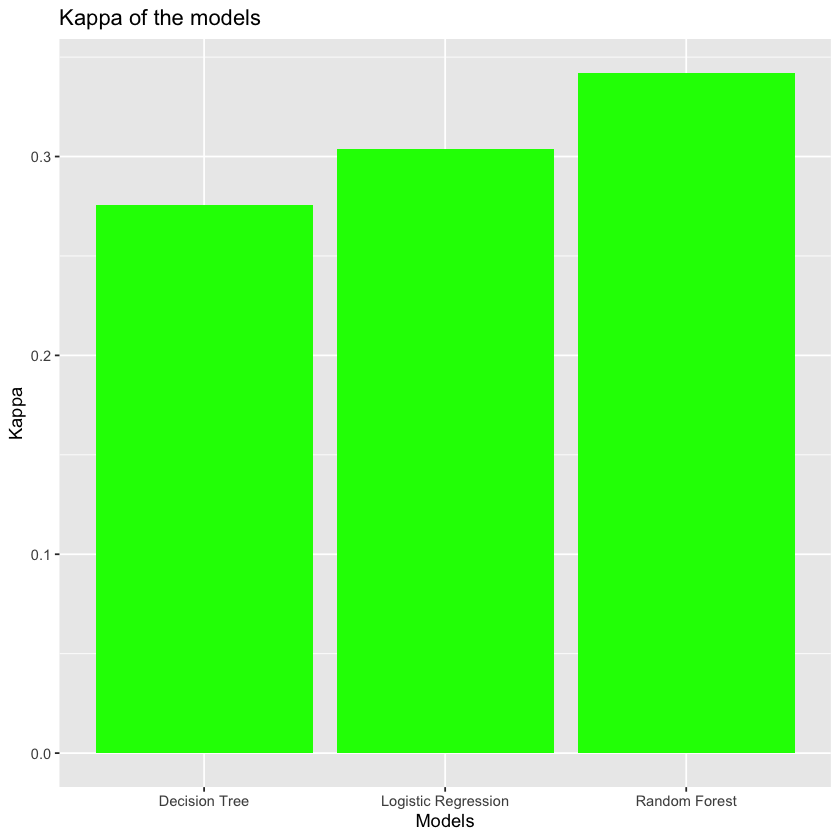

In [27]:
##Comparative of models accuracy
models <- data.frame(Model = c('Logistic Regression',
                                      'Decision Tree',
                                      'Random Forest'),
                            Accuracy = c(conf_matrix$overall[1],
                                         cm_tree$overall[1],
                                         cm_rf$overall[1]))

models1 <- data.frame(Model = c('Logistic Regression',
                                      'Decision Tree',
                                      'Random Forest'),
                            kappa = c(conf_matrix$overall[2],
                                         cm_tree$overall[2],
                                         cm_rf$overall[2]))


#Plot comparing accuracy 
ggplot(aes(x=Model, y=Accuracy), data=models) +
  geom_bar(stat='identity', fill = 'blue') +
  ggtitle('Accuracy of the models') +
  xlab('Models') +
  ylab('Accuracy')

#Plot comparing kappa 
ggplot(aes(x=Model, y=kappa), data=models1) +
  geom_bar(stat='identity', fill = 'green') +
  ggtitle('Kappa of the models') +
  xlab('Models') +
  ylab('Kappa')
     

When working with unbalanced data sets there is a risk that a model will be biased towards predicting the majority class. The models have an accuracy of around 90%, which may seem impressive at first glance. However, 88% of the data represents "no" subscriptions, so a random guess would be almost as effective.

This is where metrics like Kappa become crucial. They provide deeper insight into the performance of a model, beyond what standard accuracy measures can offer. In the context of our data set, the Kappa statistic is especially revealing. It shows that the **Random Forest** model is the most effective at correctly identifying True Positives. 

## Models Development using SMOTE ##

In [28]:
library ("DMwR")

smote_dataset <- as.data.frame(term)

#balancing the data
smote <-
  SMOTE(
    form = subscribed ~ .,
    data = smote_dataset,
    perc.over = 400,
    perc.under = 100
  )


Loading required package: grid



Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



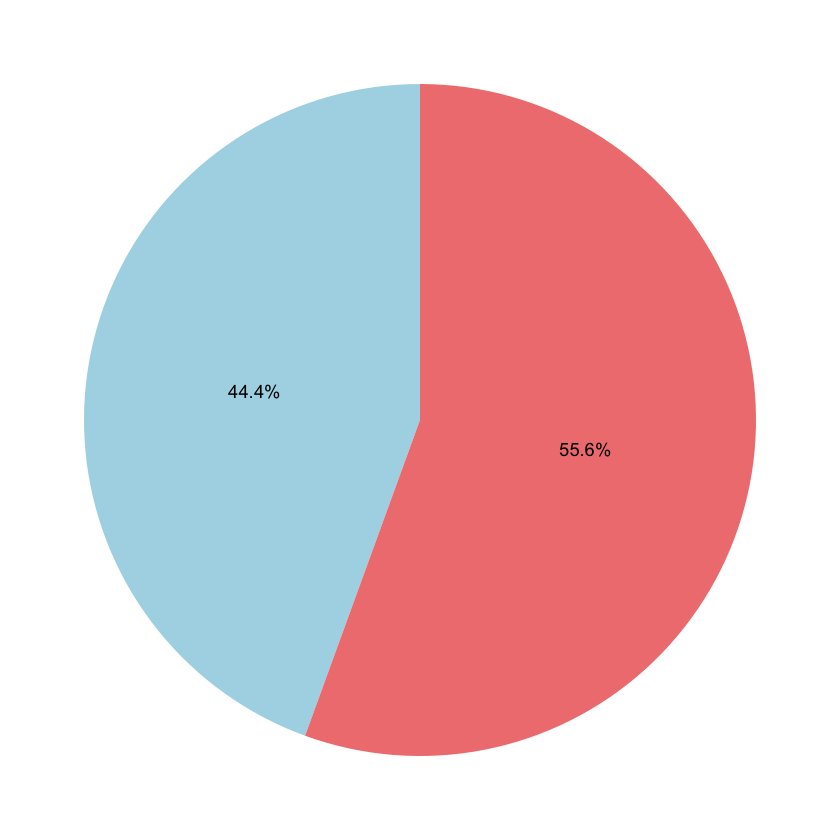

In [29]:
#graph comparing subscribed yes vs no 
#calculate the percentage of "yes" "no". 1. A table is created to see the frequency of "yes" and "no". 2. with prop table each value is divided by the sum of the total, so the percentage is calculated when the table is multiplied by 100. 3. the table is converted into a data frame 
per_subscribed_smote <- data.frame(prop.table(table(smote$subscribed)) * 100)
ggplot(per_subscribed_smote, aes(x = "", y = Freq, fill = Var1)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
  theme_void() +
  scale_fill_manual(values = c("lightblue", "lightcoral")) +
  geom_text(aes(label = sprintf("%.1f%%", Freq)), position = position_stack(vjust = 0.5))+
  theme(legend.position = "none")

### Logistic Regression, Decision Tree and Random Forest ###

In [30]:
set.seed(40425150)
index <- createDataPartition(smote$subscribed, p=0.8, list=FALSE)
train_smote <- smote[index,]
test_smote <- smote[-index,]

### Logistic Regression ###

In [31]:
formula_smote = subscribed ~ day_of_week + occupation + contact_method + campaign + month + euribor_3m + cons_price_idx + pdays
model_smote <- glm(formula = formula_smote , data = train_smote, family = "binomial")
summary(model_smote)


Call:
glm(formula = formula_smote, family = "binomial", data = train_smote)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.277e+01  3.669e+00  -8.931  < 2e-16 ***
day_of_weekmon          -1.301e-01  4.058e-02  -3.205  0.00135 ** 
day_of_weekthu          -6.977e-02  3.992e-02  -1.747  0.08056 .  
day_of_weektue          -5.363e-02  4.122e-02  -1.301  0.19326    
day_of_weekwed          -2.217e-02  4.069e-02  -0.545  0.58592    
occupationblue-collar   -3.935e-02  3.791e-02  -1.038  0.29936    
occupationentrepreneur  -3.250e-01  8.038e-02  -4.043 5.28e-05 ***
occupationhousemaid     -8.761e-02  8.348e-02  -1.049  0.29399    
occupationmanagement    -7.030e-03  5.539e-02  -0.127  0.89899    
occupationretired        3.699e-01  6.266e-02   5.902 3.58e-09 ***
occupationself-employed  1.480e-02  7.146e-02   0.207  0.83594    
occupationservices       1.135e-01  4.765e-02   2.382  0.01723 *  
occupationstudent        8.270e-01  7

**Model Performance with test data**

In [32]:
#Predictions with test data

predictions_smote <- predict(model_smote,test_smote, type = "response")
class_pred_smote <- as.factor(ifelse(predictions_smote > 0.5, "yes", "no"))
postResample(class_pred_smote, test_smote$subscribed)
conf_matrix_smote <- confusionMatrix(class_pred_smote, test_smote$subscribed, positive = "yes")
conf_matrix_smote

Accuracy     Kappa 
0.7198705 0.4372579

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  2687 1317
       yes 1019 3316
                                          
               Accuracy : 0.7199          
                 95% CI : (0.7101, 0.7295)
    No Information Rate : 0.5556          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4373          
                                          
 Mcnemar's Test P-Value : 7.998e-10       
                                          
            Sensitivity : 0.7157          
            Specificity : 0.7250          
         Pos Pred Value : 0.7649          
         Neg Pred Value : 0.6711          
             Prevalence : 0.5556          
         Detection Rate : 0.3976          
   Detection Prevalence : 0.5198          
      Balanced Accuracy : 0.7204          
                                          
       'Positive' Class : yes             
                        

Setting direction: controls < cases



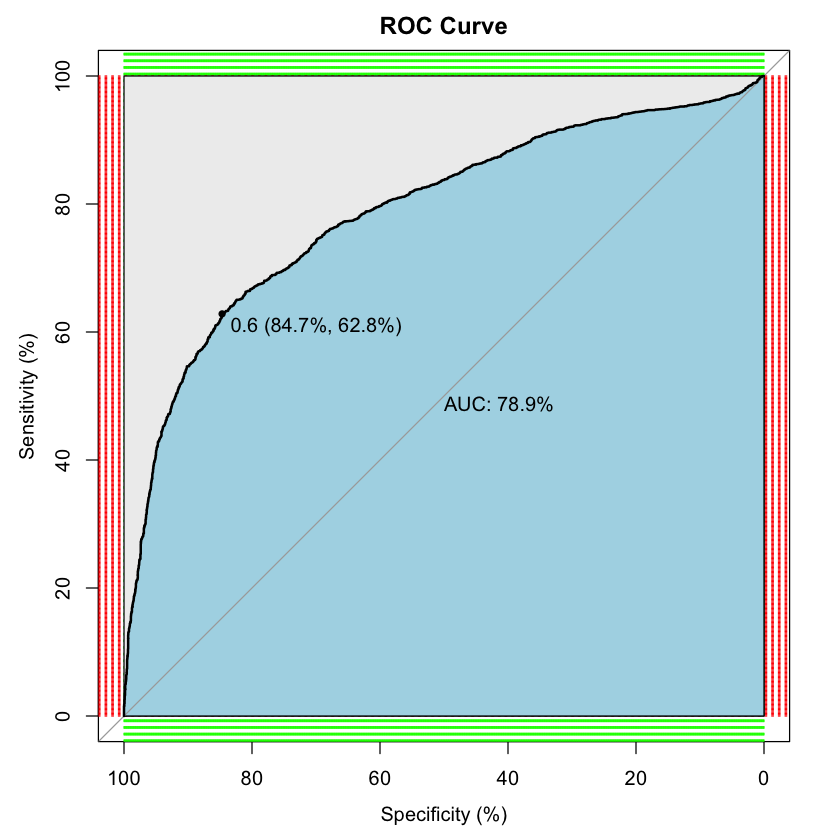

In [33]:
#ROC Curve
r_smote <- multiclass.roc(test_smote$subscribed, predictions_smote, percent = TRUE)
roc_smote <- r_smote[['rocs']]
r1_smote <- roc_smote[[1]]
plot.roc(r1_smote,
         print.auc=TRUE,
         auc.polygon=TRUE,
         grid=c(0.1, 0.2),
         grid.col=c("green", "red"),
         max.auc.polygon=TRUE,
         auc.polygon.col="lightblue",
         print.thres=TRUE,
         main= 'ROC Curve')


### Decision Tree ###

In [34]:
tree_smote <- rpart(subscribed ~ age + occupation + marital_status + education_level + credit_default + housing_loan + personal_loan + contact_method + month + day_of_week + campaign + pdays + previous_contacts + poutcome + emp_var_rate + cons_price_idx +cons_conf_idx + euribor_3m + n_employed, data = train_smote, method = "class")


**Model Performance with test data**

In [35]:
#Confusion Matrix
predictions_tree_smote <- predict(tree_smote, test_smote, type = "class")
postResample(predictions_tree_smote, test_smote$subscribed)
cm_tree_smote <- confusionMatrix(predictions_tree_smote, test_smote$subscribed)
cm_tree_smote

Accuracy     Kappa 
0.9037055 0.8061889

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  3418  515
       yes  288 4118
                                        
               Accuracy : 0.9037        
                 95% CI : (0.8972, 0.91)
    No Information Rate : 0.5556        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.8062        
                                        
 Mcnemar's Test P-Value : 1.519e-15     
                                        
            Sensitivity : 0.9223        
            Specificity : 0.8888        
         Pos Pred Value : 0.8691        
         Neg Pred Value : 0.9346        
             Prevalence : 0.4444        
         Detection Rate : 0.4099        
   Detection Prevalence : 0.4716        
      Balanced Accuracy : 0.9056        
                                        
       'Positive' Class : no            
                                        

Setting direction: controls < cases



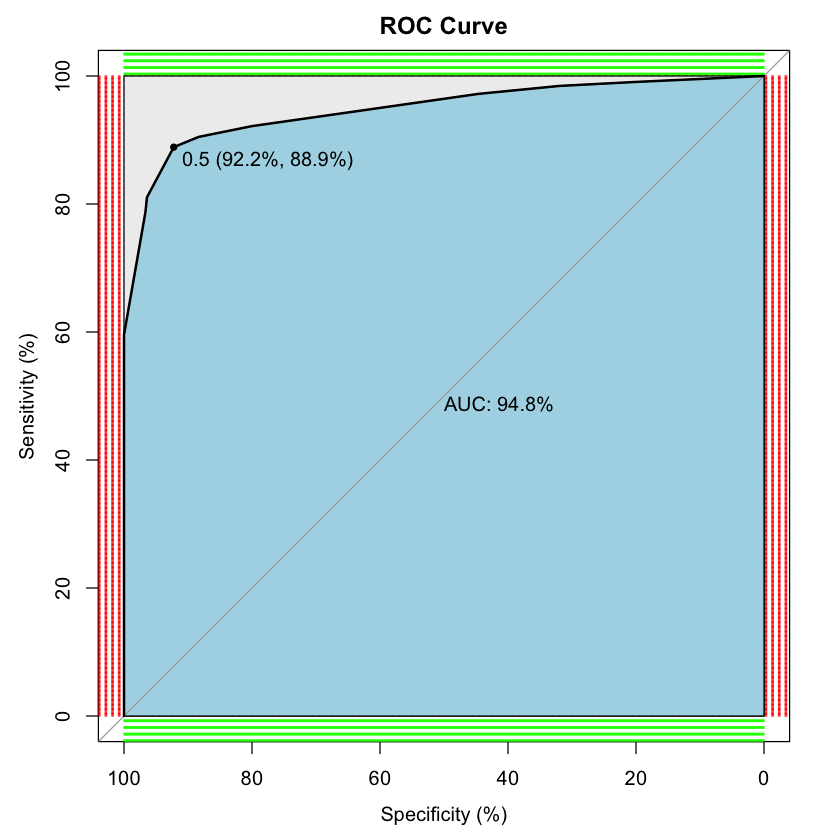

In [36]:
#ROC Curve
predictions_tree_2 <- predict(tree_smote, test_smote, type = "prob")
probabilities_tree2 <- predictions_tree_2[, "yes"]

r5<- multiclass.roc(test_smote$subscribed, probabilities_tree2, percent = TRUE)
roc_smote1 <- r5[['rocs']]
r1_smote1 <- roc_smote1[[1]]
plot.roc(r1_smote1,
         print.auc=TRUE,
         auc.polygon=TRUE,
         grid=c(0.1, 0.2),
         grid.col=c("green", "red"),
         max.auc.polygon=TRUE,
         auc.polygon.col="lightblue",
         print.thres=TRUE,
         main= 'ROC Curve')


### Random Forest ###

In [37]:
rf_smote <- randomForest(subscribed ~ age + occupation + marital_status + education_level + credit_default + housing_loan + personal_loan + contact_method + month + day_of_week + campaign + pdays + previous_contacts + poutcome + emp_var_rate + cons_price_idx +cons_conf_idx + euribor_3m + n_employed, data = train_smote)

**Model Performance with test data set**

In [38]:
#ROC Curve
pred_rf_smote <- predict(rf_smote,test_smote)
cm_rf_smote <- confusionMatrix(pred_rf_smote,test_smote$subscribed,positive = "yes")
cm_rf_smote

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  3543  442
       yes  163 4191
                                          
               Accuracy : 0.9274          
                 95% CI : (0.9217, 0.9329)
    No Information Rate : 0.5556          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8542          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9046          
            Specificity : 0.9560          
         Pos Pred Value : 0.9626          
         Neg Pred Value : 0.8891          
             Prevalence : 0.5556          
         Detection Rate : 0.5026          
   Detection Prevalence : 0.5221          
      Balanced Accuracy : 0.9303          
                                          
       'Positive' Class : yes             
                        

Setting direction: controls < cases



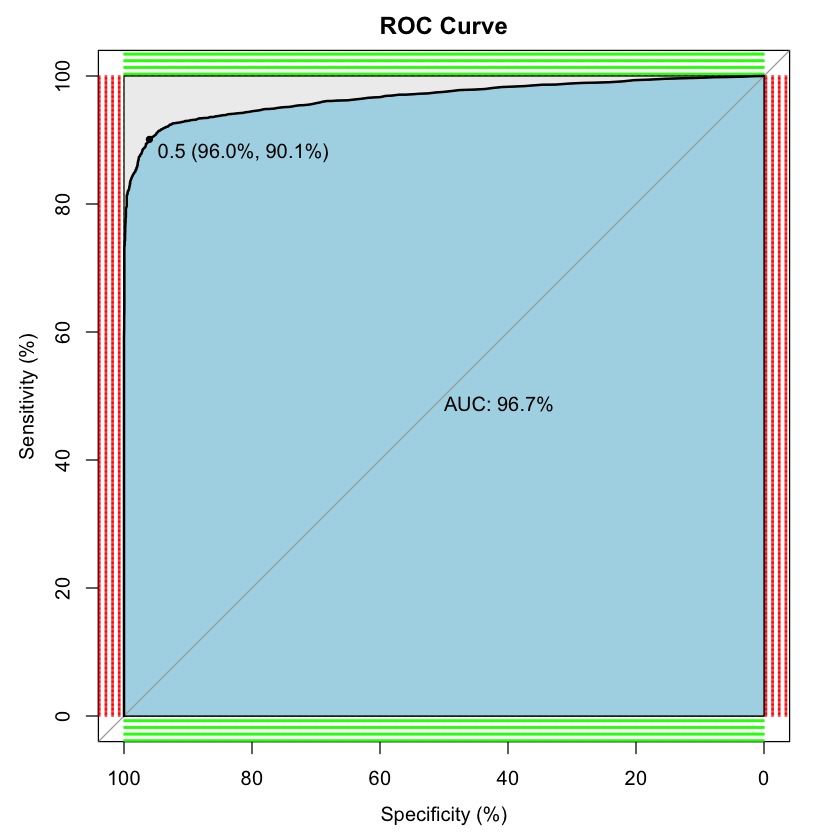

In [39]:
#ROC Curve
predictions_rf_7 <- predict(rf_smote, test_smote, type = "prob")
probabilities_rf7 <- predictions_rf_7[, "yes"]

r7 <- multiclass.roc(test_smote$subscribed, probabilities_rf7, percent = TRUE)
roc7 <- r7[['rocs']]
r7 <- roc7[[1]]
plot.roc(r7,
         print.auc=TRUE,
         auc.polygon=TRUE,
         grid=c(0.1, 0.2),
         grid.col=c("green", "red"),
         max.auc.polygon=TRUE,
         auc.polygon.col="lightblue",
         print.thres=TRUE,
         main= 'ROC Curve')

### Comparative of Models Performance ###

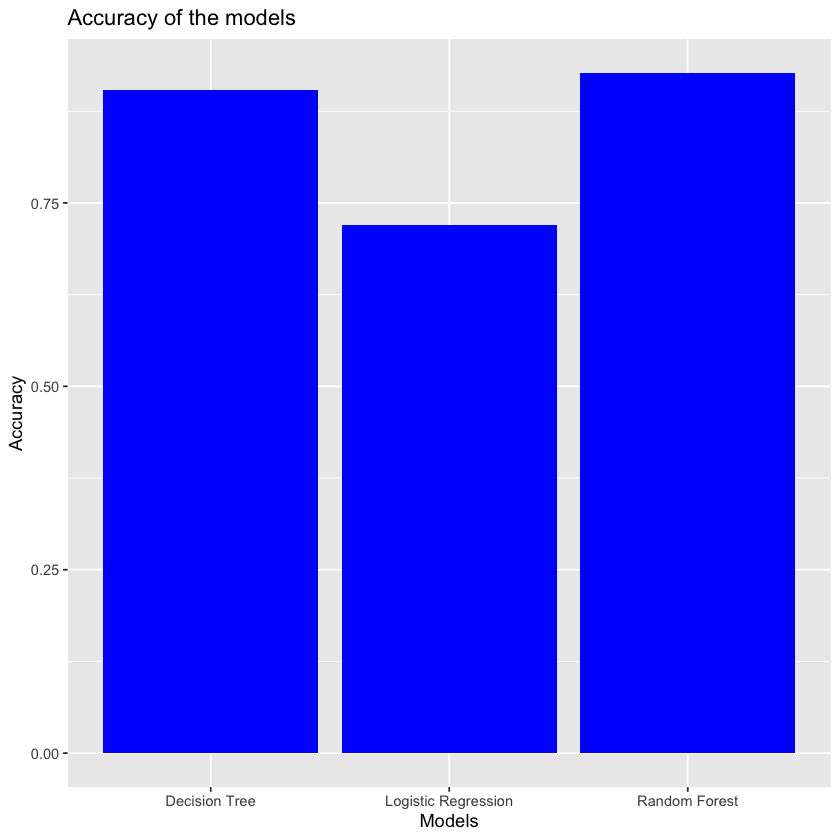

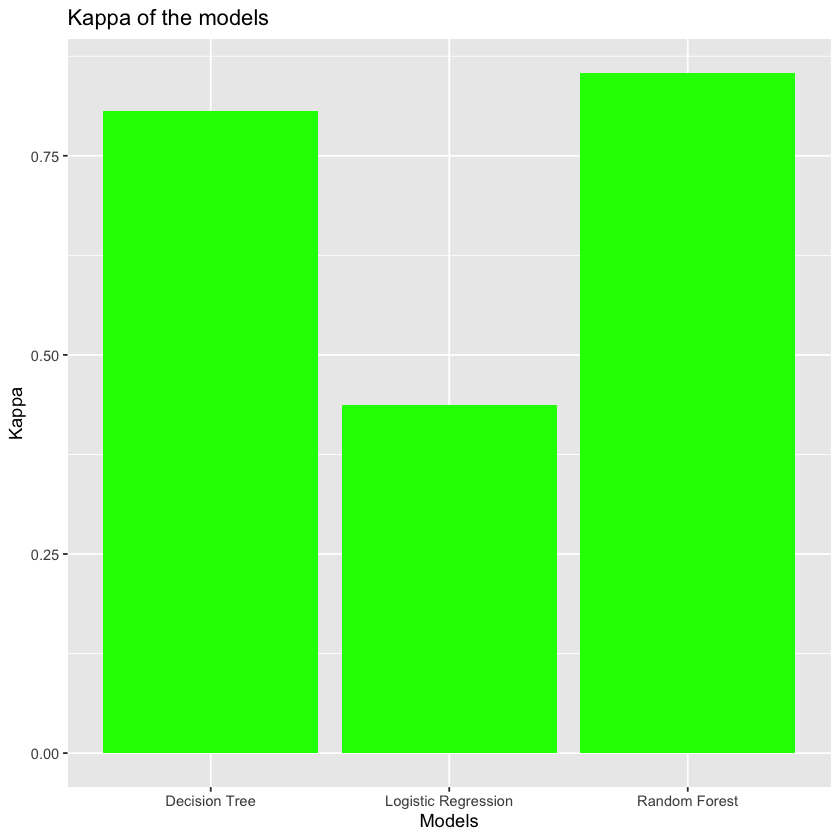

In [40]:
##Comparative of models accuracy
models <- data.frame(Model = c('Logistic Regression',
                                      'Decision Tree',
                                      'Random Forest'),
                            Accuracy = c(conf_matrix_smote$overall[1],
                                         cm_tree_smote$overall[1],
                                         cm_rf_smote$overall[1]))

models1 <- data.frame(Model = c('Logistic Regression',
                                      'Decision Tree',
                                      'Random Forest'),
                            kappa = c(conf_matrix_smote$overall[2],
                                         cm_tree_smote$overall[2],
                                         cm_rf_smote$overall[2]))


#Plot comparing accuracy 
ggplot(aes(x=Model, y=Accuracy), data=models) +
  geom_bar(stat='identity', fill = 'blue') +
  ggtitle('Accuracy of the models') +
  xlab('Models') +
  ylab('Accuracy')

#Plot comparing kappa 
ggplot(aes(x=Model, y=kappa), data=models1) +
  geom_bar(stat='identity', fill = 'green') +
  ggtitle('Kappa of the models') +
  xlab('Models') +
  ylab('Kappa')

After applying the SMOTE technique to balance our dataset, the performance of our models has improved notably. The best model is again the **Random Forest** model, which an accuracy of 0.92. This metric is particularly valuable, given that it reflects the performance in a balanced dataset scenario, unlike our previous model evaluations where the data was heavily biased towards the 'no' subscriptions.

Moreover, in terms of the Kappa statistic, the Random Forest model again stands out with the highest score of 0.84. 